**Import Libraries**

In [1]:
import nltk
import math
import os
import sys
import string
import operator
import numpy as np
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

**Read from Path**

In [2]:
def readFromPath(path, mapping_dict, folders_to_scan):
    print("Entering readFromPath")
    document_dict = {}
    doc_length_dict = {}
    for foldername in os.listdir(path):
        if os.path.isdir(path+"/"+foldername) and foldername in folders_to_scan:
            complete_path = path+"/"+ foldername
            for filename in os.listdir(complete_path):
                word_counter = 0
                word_dict = {}
                f = open(complete_path+"/"+filename, errors="ignore")
                data = f.read()
                tokens = nltk.word_tokenize(data) # Tokenize the data of the file
                stripped = removePunctuation(tokens) # Punctuation removal
                lemmatized_words = lemmatization(stripped) # Lemmatization
                filtered_words = removeStopwords(lemmatized_words) # Stopword Removal
                doc_length_dict[mapping_dict[foldername+'-'+filename]] = len(filtered_words)
                for word in filtered_words:
                    if word in word_dict.keys():
                        word_counter = word_dict[word] + 1
                    else:
                        word_counter = 1
                    word_dict[word] = word_counter/(doc_length_dict[mapping_dict[foldername+'-'+filename]])
                document_dict[mapping_dict[foldername+'-'+filename]] = word_dict
    print("Corpus collection done")
    print("Exiting readFromPath")
    return document_dict,doc_length_dict

**Create Document Mapping**

In [3]:
def createDocumentMapping(path, folders_to_scan):
    print("Entering createDocumentMapping")
    mapping_dict = {}
    count = 0
    for foldername in os.listdir(path):
        if os.path.isdir(path+"/"+foldername) and foldername in folders_to_scan:
            complete_path = path+"/"+ foldername
            for filename in os.listdir(complete_path):
                mapping_dict[foldername+'-'+filename] = count
                count += 1
    print("Exiting createDocumentMapping")
    return mapping_dict

**Punctuation Removal**

In [4]:
# Removal of punctuations from the tokens list
def removePunctuation(tokens):
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    return stripped

**Stopword Removal**

In [5]:
# Removal of stopwords from the tokens list
def removeStopwords(text_list):
    stop_words=set(stopwords.words("english"))
    filtered_text = []
    for w in text_list:
        if w not in stop_words:
            filtered_text.append(w)
    return filtered_text

**Lemmatization**

In [6]:
# Lowercase conversion
# Lemmatizing the words present in the list containing text
def lemmatization(text_list):
    lem = WordNetLemmatizer()
    lemmatized_words = []
    for w in text_list:
        w = w.lower()
        word = lem.lemmatize(w)
        lemmatized_words.append(word)
    return lemmatized_words

In [7]:
path = os.getcwd() + '\\20_newsgroups'

folders_to_scan = ['comp.graphics', 'sci.med', 'talk.politics.misc', 'rec.sport.hockey', 'sci.space']

mapping_dict = createDocumentMapping(path, folders_to_scan)

document_dict, doc_length_dict= readFromPath(path, mapping_dict, folders_to_scan)

Entering createDocumentMapping
Exiting createDocumentMapping
Entering readFromPath
Corpus collection done
Exiting readFromPath


**Find Document Frequency**

In [8]:
# Find df corresponding to all the words in all the documents 
def findDfAllDocs(document_dict):
    df_dict = {}
    no_of_docs = 0
    for document in document_dict.keys():
        no_of_docs += 1
        df_counter = 0
        word_dict = document_dict[document]
        for word in word_dict.keys():
            if word in df_dict.keys():
                df_counter = df_dict[word] + 1
            else:
                df_counter = 1
            df_dict[word] = df_counter
    return df_dict, no_of_docs

In [9]:
df_dict, no_of_docs = findDfAllDocs(document_dict)

**FindTfIdf**

In [10]:
def findTfIdf(document_dict, doc_length_dict, df_dict):
    tf_idf_score = {}
    for document in document_dict.keys():
        total_score = 0
        N = doc_length_dict[document]
        word_dict = document_dict[document]
        term_dict = {}        
        for term in word_dict.keys():
            tf = word_dict[term]
            df = df_dict[term]
            normalizedTf = tf/N # BNormalized TF
            idf = 1 + math.log((no_of_docs/df),2) # Normalized IDF
            total_score = normalizedTf * idf
            term_dict[term] = total_score
        tf_idf_score[document] = term_dict
    return tf_idf_score

**Find Tf-Idf for Input Query**

In [11]:
def findTfIdfInputQuery(document_dict, df_dict, input_wordList, input_string_length):
    input_query_tfidf = {}
    for document in document_dict.keys():
        word_dict = document_dict[document]
        for term in word_dict.keys():
            df = df_dict[term]
            idf = 1 + math.log((no_of_docs/df),2)
            if term in input_wordList:
                input_query_tfidf[term] = ((input_wordList.count(term)/input_string_length) * idf)
    return input_query_tfidf       

**Finding total Vocab**

In [12]:
vocab_size = len(df_dict)
vocab = []
for x in df_dict.keys():
    vocab.append(x)

In [13]:
print(len(vocab))

79216


**Generate Vocabulary Vector**

In [14]:
def generate_vocab_vector(no_of_docs, vocab_size, vocab, tf_idf_score):
    print("Entering generate_vocab_vector")
    vector = np.zeros((no_of_docs,vocab_size))
    for doc in tf_idf_score.keys():
        word_dict = tf_idf_score[doc]
        for word in word_dict.keys():
            position = vocab.index(word)
            vector[doc][position] = word_dict[word]
    print("Exiting generate_vocab_vector")
    return vector

**Generate Query Vector**

In [15]:
def generate_query_vector(no_of_docs, vocab_size, vocab, input_query_tfidf):
    print("Entering generate_query_vector")
    vector = np.zeros((vocab_size))
    for word in input_query_tfidf.keys():
        position = vocab.index(word)
        vector[position] = input_query_tfidf[word]
    print("Exiting generate_query_vector")
    return vector

**Find Centroid**

In [16]:
def find_centroid(doc_list, vector):
    lst = []
    for doc in doc_list:
        lst.append(vector[doc])
    return np.array(lst).sum(axis=0)/len(doc_list)

**Find Cosine Similarity**

In [17]:
def getCosineSim(query,k): # top k
    doc_cosines = []
    for i in range(len(vocab_vector)):
        doc_vector = vocab_vector[i]
        if i not in annotated_docs:
            cosine_val = dot(query, doc_vector)/(norm(query)*norm(doc_vector))
            doc_cosines.append(cosine_val)
    output_docs = np.array(doc_cosines).argsort()[-k:][::-1]
    return list(output_docs), doc_cosines

**Get Feedback for relevant documents**

In [18]:
def get_feedback(docs, ground_truth, feedback_list, p):
    #inp = input("Enter index of relevant docs from output of results:")
    #rel = inp.split()
    rel = []
    if len(feedback_list) <= p:
        rel = feedback_list[:]
    else:
        rel = feedback_list[:p]
    non_rel_docs = []
    rel_docs = []
    for i in rel:
        rel_docs.append(docs[int(i)])
    rest_docs = set(docs) - set(rel_docs)
    non_rel_docs = list(rest_docs)
    
    return rel_docs, non_rel_docs, len(rel)

**Preprocess Input String**

In [19]:
# Parsing the input string
def parseInputString(input_string):
    wordList = tokens = nltk.word_tokenize(input_string) # Tokenizing the input string
    wordList = removePunctuation(wordList)
    lemmatized_wordList = lemmatization(wordList)  # Lemmatizing the words
    input_wordList = removeStopwords(lemmatized_wordList)
    print("After filtering:::",input_wordList)
    input_string_length = len(input_wordList)   # Finding the length of input list
    return input_wordList,input_string_length

In [20]:
tf_idf_score = findTfIdf(document_dict, doc_length_dict, df_dict)
vocab_vector = generate_vocab_vector(no_of_docs, vocab_size, vocab, tf_idf_score)

Entering generate_vocab_vector
Exiting generate_vocab_vector


In [21]:
import pickle
pickle_out= open("vocab_vector.pickle","wb")
pickle.dump(vocab_vector, pickle_out)
pickle_out.close()

In [22]:
input_string = input("Enter the input query:")
input_wordList, input_string_length = parseInputString(input_string)
input_query_tfidf = findTfIdfInputQuery(document_dict, df_dict, input_wordList, input_string_length)

Enter the input query:Pretty good opinions on biochemistry machines
After filtering::: ['pretty', 'good', 'opinion', 'biochemistry', 'machine']


In [27]:
pickle_in = open("vocab_vector.pickle","rb")
vocab_vector=pickle.load(pickle_in)
pickle_in.close()

In [28]:
query_vector = generate_query_vector(no_of_docs,vocab_size, vocab, input_query_tfidf)
print("Query and vocab vector generated")

Entering generate_query_vector
Exiting generate_query_vector
Query and vocab vector generated


In [29]:
def plotTSNE(q_relevant, q_nonrelevant, q_m, vocab_vector):
    tsne_model = TSNE(n_components=2, random_state=0)
    
    feature_list = []
    labels_list = []

    for i in q_relevant:
        feature_list.append(vocab_vector[i])
        labels_list.append(0)
    for i in q_nonrelevant:
        feature_list.append(vocab_vector[i])
        labels_list.append(1)

    feature_list.append(q_m)
    labels_list.append(2)

    transformed_data = tsne_model.fit_transform(np.array(feature_list))
    transformed_data_arr = np.array(transformed_data)
    color_list = []
    for i in labels_list:
        if i == 0:
            color_list.append('Blue')
        elif i == 1:
            color_list.append('Violet')
        else:
            color_list.append('Red')
    
    plt.scatter(transformed_data_arr[:, 0], transformed_data_arr[:, 1], c = color_list,s=80, alpha=0.8, label = "Violet-NR, Blue-R")
    plt.title("Rocchio Algorithm")
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
def getGroundTruthDocuments(folder_name, mapping_dict):
    groundTruthList = []
    for folder_doc in mapping_dict.keys():
        if folder_name in folder_doc:
            groundTruthList.append(mapping_dict[folder_doc])
    return groundTruthList

In [31]:
def getKeysByValue(dictOfElements, valueToFind):
    key = -1
    listOfItems = dictOfElements.items()
    for item in dictOfElements.keys():
        if dictOfElements[item] == valueToFind:
            key = item
            break
    return key

In [32]:
k = int(input("Enter the top k(k >= 100):"))
p = int(input("Enter the values of p(p% relevant):"))
relevant_folder = input("Enter the relevant folder:")

Enter the top k(k >= 100):200
Enter the values of p(p% relevant):25
Enter the relevant folder:sci.med


Enter number of iterations to perform:4

Iteration 1
q_m: [0. 0. 0. ... 0. 0. 0.]
0 361 comp.graphics-38523
1 435 comp.graphics-38597
2 ** 2040 ** sci.med-58082
3 ** 2477 ** sci.med-59116
4 612 comp.graphics-38774
5 ** 2760 ** sci.med-59400
6 ** 2983 ** sci.med-59632
7 ** 2753 ** sci.med-59393
8 ** 2349 ** sci.med-58987
9 ** 2593 ** sci.med-59233
10 ** 2175 ** sci.med-58813
11 79 comp.graphics-38240
12 3803 sci.space-61454
13 507 comp.graphics-38669
14 ** 2864 ** sci.med-59504
15 3939 sci.space-62386
16 1246 rec.sport.hockey-53646
17 4989 talk.politics.misc-179106
18 ** 2962 ** sci.med-59602
19 597 comp.graphics-38759
20 675 comp.graphics-38837
21 ** 2404 ** sci.med-59043
22 1391 rec.sport.hockey-53791
23 1015 rec.sport.hockey-52565
24 797 comp.graphics-38959
25 ** 2234 ** sci.med-58872
26 580 comp.graphics-38742
27 376 comp.graphics-38538
28 1277 rec.sport.hockey-53677
29 568 comp.graphics-38730
30 ** 2478 ** sci.med-59117
31 ** 2444 ** sci.med-59083
32 ** 2567 ** sci.med-59207
33 ** 

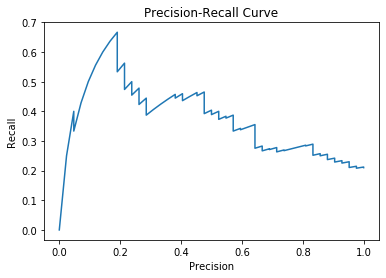

List of relevant documents: {2819, 2567, 2183, 2315, 2444, 2318, 2962, 2040, 2585, 2460, 2848, 2593, 2598, 2983, 2473, 2476, 2477, 2349, 2478, 2864, 2745, 2234, 2878, 2753, 2760, 2122, 2906, 2908, 2526, 2404, 2661, 2024, 2668, 2924, 2543, 2163, 2420, 2421, 2424, 2683, 2940, 2175}
List of non relevant documents: {4097, 1028, 10, 4107, 3084, 3085, 23, 31, 1060, 1573, 37, 568, 57, 570, 1595, 4156, 1596, 4158, 1598, 576, 580, 3658, 3147, 79, 1103, 4688, 3667, 597, 4699, 4188, 3678, 608, 612, 1124, 4197, 110, 1650, 1146, 1660, 4221, 1665, 1154, 4233, 1164, 143, 1169, 1684, 1698, 675, 1700, 1702, 683, 1198, 3246, 1201, 180, 4789, 4284, 4796, 707, 201, 716, 1230, 3803, 1245, 1246, 4830, 3302, 231, 234, 746, 1263, 753, 762, 1277, 770, 773, 1287, 3848, 1802, 1292, 269, 4366, 3855, 1296, 1810, 276, 1302, 4375, 280, 793, 4379, 797, 1825, 290, 803, 1318, 296, 1320, 316, 831, 1862, 4422, 838, 1863, 3916, 1357, 3919, 1879, 3417, 1373, 3939, 1379, 356, 870, 361, 362, 363, 4974, 1391, 376, 889, 1915, 

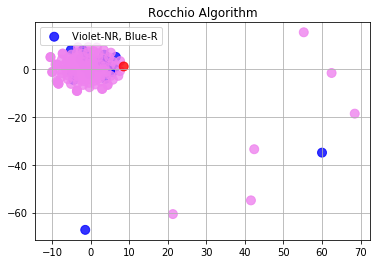


Iteration 2
alpha_val: [0. 0. 0. ... 0. 0. 0.]
beta_val: [4.62229562e-06 1.29965263e-05 1.29255105e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
gamma_val: [3.12346193e-06 6.06472709e-06 6.03284870e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
q_m: [1.49883369e-06 6.93179922e-06 6.89266183e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
0 3650 sci.space-61301
1 843 comp.graphics-39006
2 1145 rec.sport.hockey-53545
3 4726 talk.politics.misc-178842
4 3863 sci.space-61514
5 ** 2470 ** sci.med-59109
6 45 comp.graphics-37957
7 1119 rec.sport.hockey-52669
8 239 comp.graphics-38400
9 795 comp.graphics-38957
10 96 comp.graphics-38257
11 3131 sci.space-60781
12 ** 2080 ** sci.med-58122
13 ** 2306 ** sci.med-58944
14 1102 rec.sport.hockey-52652
15 658 comp.graphics-38820
16 4673 talk.politics.misc-178789
17 ** 2381 ** sci.med-59020
18 ** 2369 ** sci.med-59008
19 462 comp.graphics-38624
20 ** 2240 ** sci.med-58878
21 ** 2262 ** sci.med-58900
22 3140 sci.space-60790
23 77

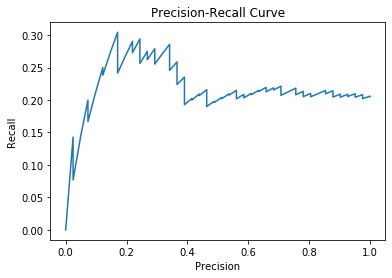

List of relevant documents: {2304, 2306, 2819, 2567, 2825, 2315, 2572, 2318, 2062, 2832, 2064, 2585, 2330, 2848, 2593, 2080, 2598, 2347, 2092, 2349, 2864, 2610, 2874, 2878, 2369, 2884, 2122, 2381, 2906, 2908, 2658, 2404, 2661, 2149, 2668, 2924, 2926, 2163, 2420, 2421, 2935, 2424, 2682, 2683, 2940, 2430, 2175, 2183, 2444, 2703, 2962, 2712, 2460, 2212, 2470, 2983, 2727, 2473, 2476, 2477, 2478, 2479, 2739, 2745, 2234, 2240, 2753, 2247, 2760, 2254, 2001, 2262, 2008, 2522, 2524, 2268, 2526, 2024, 2543, 2807, 2040, 2813}
List of non relevant documents: {1024, 4097, 1028, 10, 4107, 3084, 3085, 3089, 3091, 23, 4122, 31, 1060, 37, 36, 4134, 45, 1071, 57, 3131, 4156, 60, 4158, 3139, 3140, 4166, 3147, 75, 1100, 1101, 79, 1103, 1102, 1107, 4185, 90, 4188, 1119, 96, 1122, 1124, 4197, 102, 110, 4206, 1145, 1146, 4221, 4224, 4225, 1154, 4232, 4233, 1164, 4236, 3214, 143, 1169, 4242, 1174, 1187, 4261, 1198, 3246, 1201, 180, 3258, 3259, 4284, 188, 201, 1230, 4303, 3280, 1236, 3284, 3292, 1245, 1246, 32

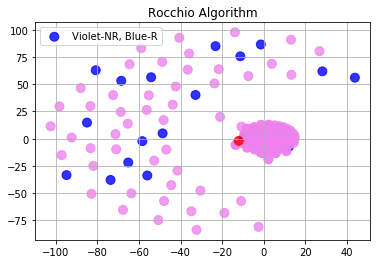


Iteration 3
alpha_val: [1.49883369e-06 6.93179922e-06 6.89266183e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
beta_val: [5.85436924e-06 1.56588642e-05 1.55663464e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
gamma_val: [3.95659466e-06 6.70278764e-06 6.66362821e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
q_m: [3.39660826e-06 1.58878757e-05 1.57953800e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
0 3502 sci.space-61153
1 814 comp.graphics-38977
2 1100 rec.sport.hockey-52650
3 4530 talk.politics.misc-178645
4 3701 sci.space-61352
5 43 comp.graphics-37955
6 1074 rec.sport.hockey-52624
7 228 comp.graphics-38389
8 766 comp.graphics-38928
9 3001 sci.space-59846
10 1997 rec.sport.hockey-54897
11 ** 2210 ** sci.med-58848
12 1059 rec.sport.hockey-52609
13 636 comp.graphics-38798
14 4477 talk.politics.misc-178592
15 ** 2283 ** sci.med-58921
16 ** 2271 ** sci.med-58909
17 446 comp.graphics-38608
18 ** 2147 ** sci.med-58785
19 ** 2167 ** sci.med-58805
20 3008

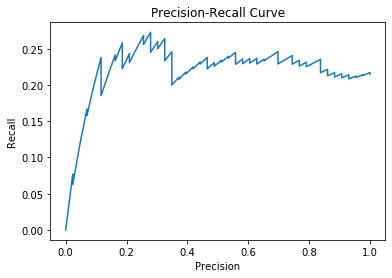

List of relevant documents: {2304, 2306, 2819, 2567, 2825, 2315, 2572, 2571, 2318, 2062, 2832, 2064, 2060, 2585, 2330, 2591, 2848, 2593, 2080, 2598, 2600, 2347, 2092, 2349, 2864, 2610, 2614, 2874, 2878, 2880, 2369, 2625, 2883, 2884, 2120, 2377, 2122, 2381, 2906, 2908, 2658, 2147, 2404, 2661, 2149, 2920, 2153, 2923, 2668, 2924, 2926, 2160, 2163, 2420, 2421, 2419, 2935, 2424, 2167, 2682, 2683, 2940, 2173, 2430, 2175, 2941, 2691, 2183, 2697, 2444, 2703, 2962, 2963, 2965, 2709, 2712, 2460, 2716, 2208, 2210, 2466, 2212, 2470, 2983, 2727, 2473, 2982, 2476, 2477, 2478, 2479, 2739, 2745, 2234, 2240, 2753, 2754, 2757, 2502, 2247, 2760, 2249, 2254, 2767, 2001, 2262, 2008, 2522, 2524, 2268, 2526, 2271, 2789, 2024, 2283, 2543, 2550, 2807, 2040, 2806, 2813}
List of non relevant documents: {1024, 4097, 1028, 1029, 10, 4107, 3084, 3085, 3082, 3089, 3091, 23, 4120, 4122, 31, 1057, 1058, 1059, 1060, 37, 36, 4134, 35, 1063, 43, 45, 1071, 4143, 1074, 1077, 3126, 3127, 57, 3131, 4156, 60, 4158, 3139, 3140

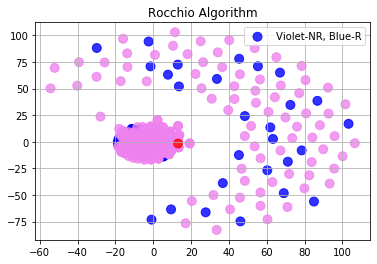


Iteration 4
alpha_val: [3.39660826e-06 1.58878757e-05 1.57953800e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
beta_val: [1.01762465e-05 1.85768583e-05 1.84707532e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
gamma_val: [4.12988322e-06 6.80332847e-06 6.76447971e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
q_m: [9.44297149e-06 2.76614055e-05 2.75016535e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
0 3360 sci.space-61011
1 787 comp.graphics-38949
2 1059 rec.sport.hockey-52609
3 4348 talk.politics.misc-178462
4 3546 sci.space-61197
5 41 comp.graphics-37953
6 222 comp.graphics-38383
7 740 comp.graphics-38902
8 ** 2882 ** sci.med-59522
9 1917 rec.sport.hockey-54562
10 ** 2123 ** sci.med-58761
11 1019 rec.sport.hockey-52569
12 616 comp.graphics-38778
13 4295 talk.politics.misc-178409
14 ** 2194 ** sci.med-58832
15 ** 2182 ** sci.med-58820
16 433 comp.graphics-38595
17 ** 2062 ** sci.med-58104
18 ** 2081 ** sci.med-58123
19 ** 2888 ** sci.med-59528
20 719

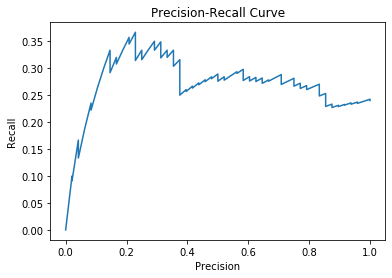

List of relevant documents: {2567, 2571, 2572, 2060, 2062, 2064, 2068, 2582, 2585, 2586, 2074, 2591, 2080, 2593, 2081, 2598, 2087, 2600, 2092, 2604, 2610, 2614, 2625, 2120, 2121, 2122, 2123, 2640, 2643, 2653, 2658, 2147, 2661, 2149, 2153, 2668, 2160, 2161, 2163, 2675, 2167, 2682, 2683, 2173, 2175, 2691, 2182, 2183, 2697, 2698, 2703, 2194, 2709, 2712, 2716, 2208, 2210, 2212, 2727, 2739, 2745, 2234, 2240, 2753, 2754, 2757, 2247, 2760, 2249, 2761, 2764, 2254, 2767, 2262, 2268, 2271, 2789, 2283, 2801, 2804, 2806, 2807, 2299, 2813, 2304, 2306, 2819, 2822, 2825, 2315, 2318, 2832, 2324, 2326, 2330, 2844, 2846, 2848, 2347, 2349, 2863, 2864, 2874, 2878, 2880, 2369, 2368, 2883, 2884, 2882, 2887, 2888, 2377, 2381, 2906, 2908, 2402, 2404, 2920, 2923, 2924, 2926, 2419, 2420, 2421, 2935, 2424, 2940, 2941, 2430, 2444, 2447, 2961, 2962, 2963, 2965, 2460, 2466, 2467, 2470, 2983, 2982, 2473, 2476, 2477, 2478, 2479, 2487, 2496, 2502, 2510, 2001, 2519, 2008, 2522, 2524, 2526, 2024, 2543, 2035, 2550, 2040}

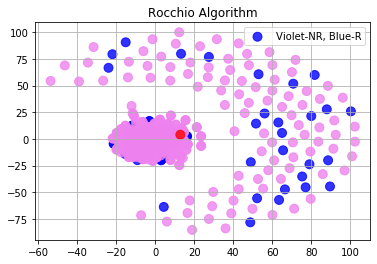

In [33]:
annotated_docs = []
alpha = 1
beta = 0.7
gamma = 0.25
#np.set_printoptions(threshold=sys.maxsize)
noOfIterations = input("Enter number of iterations to perform:")
for i in range(int(noOfIterations)):
    print("\nIteration", i+1)
    if i == 0:
        q_m = query_vector
        q_relevant = set()
        q_nonrelevant = set()
    else:
        q_prev = q_m
        alpha_val = (alpha*q_prev)
        beta_val = (beta*find_centroid(q_relevant, vocab_vector))
        gamma_val = (gamma*find_centroid(q_nonrelevant, vocab_vector))
        q_m = alpha_val + beta_val - gamma_val
        print("alpha_val:",alpha_val)
        print("beta_val:",beta_val)
        print("gamma_val:",gamma_val)
    print("q_m:",q_m)
    q_m = np.where(q_m<0,0,q_m)
    docsFromCosine,doc_cosine = getCosineSim(q_m, k)
    ground_truth = getGroundTruthDocuments(relevant_folder, mapping_dict)
    x = -1
    feedback_list = []
    for doc in docsFromCosine:
        x += 1
        if doc in ground_truth:
            feedback_list.append(x)
            print(x,"**",doc,"**",getKeysByValue(mapping_dict, doc))
        else:
            print(x,doc,getKeysByValue(mapping_dict, doc))
    t = int((p*k)/100)
    rel_docs, non_rel_docs, rel_size = get_feedback(docsFromCosine,ground_truth, feedback_list, t)
    # Precision Recall Curve Start
    precision_list = []
    recall_list = []
    classified = 0
    map_value = 0
    count = 1
    for doc in docsFromCosine:
        precision_list.append(classified/count)
        recall_list.append(classified/rel_size)
        if doc in rel_docs:
            classified += 1
            map_value += (classified/count)
        count += 1
    print("MAP:", map_value/rel_size) # Finding the MAP value
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall Curve')
    plt.plot(recall_list, precision_list)
    plt.show()
    # Precision Recall Curve End
    
    q_relevant = q_relevant | set(rel_docs)
    q_nonrelevant = q_nonrelevant | set(non_rel_docs)
    
    print("List of relevant documents:",q_relevant)
    print("List of non relevant documents:",q_nonrelevant)
    annotated_docs += q_relevant
    annotated_docs += q_nonrelevant
    
    plotTSNE(q_relevant, q_nonrelevant, q_m, vocab_vector)